meta NOT subset; don't know how to subset; dropped


The overall accuracy of Occurrence Prediction for training: 86.13%
The overall accuracy of Occurrence Prediction for testing: 84.42%
[[1145  243]
 [ 116  800]]
Time for training the regression model: 0.4647s
MSE and R2 and MAE of Training: 0.1387 and 0.42 and 0.14
MSE and R2 and MAE of Prediction: 0.1558 and 0.35 and 0.16


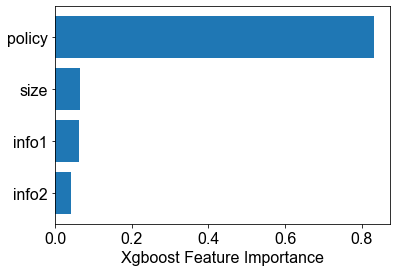

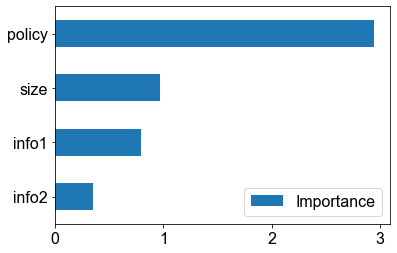

In [20]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

df = pd.read_csv('data_final.csv')
k =df.id.unique()

dk = pd.DataFrame()
dj = pd.DataFrame()

for i in k:
    
    dg= df.loc[df['id'] == i]
    p70 = dg.sample(frac = 0.70)
  
# Creating dataframe with 
# rest of the 30% values
    rp30 = dg.drop(p70.index)
    dk = pd.concat([dk,p70])
    dj = pd.concat([dj,rp30])
# see pd.concat documentation for more info

dm = dk.sample(frac = 1)
dn = dj.sample(frac = 1)
gf = pd.concat([dm, dn])

df_dum = gf

del df_dum['id']

df_dum.to_csv('r.csv', index=False)

import shap
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from joblib import dump
from joblib import load
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.compose import TransformedTargetRegressor
from matplotlib import pyplot
import time
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

TIMEFORMAT = '%m/%d/%y %H:%M'
TIMEFORMAT1 = '%m/%d/%y'

import warnings
warnings.filterwarnings("ignore")

def prdBMPXGBoost(datasets1, target, variables):

    # check if all variables is in datasets1
    colnames = datasets1.columns.to_list()
    if not all(col in colnames for col in variables):
        print('not all variables appear in the datasets 2')
        exit()

    #########################################################################################
    # Phase 1: training
    #########################################################################################
    # training data (70%) for the prediction of the BMP adoption decision
    m = datasets1.shape[0]
    b = np.array(['size',
    'policy',
    'info1',
    'info2'
    ])
    
    mt = int(m*0.70)
 
    # training data (70%) for the prediction of the BMP adoption decision
    tr_m_xv = (datasets1.loc[0:mt, variables])
    
    tr_m_yv_obs = (datasets1.loc[0:mt, target])
    
    # validation data (30%) for the prediction of the BMP adoption decision
    val_m_xv = (datasets1.loc[mt:, variables])
    val_m_yv_obs = (datasets1.loc[mt:, target])
     
    ########################################################################################
    # XGBoost Classifier
    ########################################################################################
    start = time.time()   
    
    # training the XGBoost models
    cv_cl_mod = xgb.XGBClassifier(
         
        learning_rate= 0.1, max_depth= 5, min_child_weight= 7, 
        
        objective= 'binary:hinge'
       )

    cv_cl_mod.fit(tr_m_xv, tr_m_yv_obs)
    
    explainer = shap.TreeExplainer(cv_cl_mod)
    shap_values = explainer.shap_values(tr_m_xv)
    
    importance = cv_cl_mod.feature_importances_

    t_c_yv_mod = cv_cl_mod.predict(tr_m_xv)
    prediction1 = accuracy_score(tr_m_yv_obs, t_c_yv_mod)
    print('The overall accuracy of adoption decision Prediction for training: {0:.2f}%'.format(prediction1*100))
    
    val_c_yv_mod = cv_cl_mod.predict(val_m_xv)
    prediction = accuracy_score(val_m_yv_obs, val_c_yv_mod)
    print('The overall accuracy of adoption decision Prediction for testing: {0:.2f}%'.format(prediction*100))
    
    hh = confusion_matrix(val_m_yv_obs, val_c_yv_mod)
    print(hh)
    
    sorted_idx = cv_cl_mod.feature_importances_.argsort()
    plt.barh(b[sorted_idx], cv_cl_mod.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")
    
    shap_imp_pd=pd.DataFrame(
    index=b, 
    data = np.mean(np.absolute(shap_values), axis = 0), 
    columns=["Importance"])
    shap_imp_pd.sort_values(
    by=['Importance']).plot.barh(y='Importance')
    
    plt.rcParams.update({'font.family':'Arial'})
    plt.rcParams.update({'font.size': 16})
    plt.savefig('SXGBfimportance.pdf')

    tr_m_yv_mod = cv_cl_mod.predict(tr_m_xv)

    end = time.time()
    print("Time for training the classification model: {0:.4f}s".format(end - start))
    
    dump(cv_cl_mod, "cl.joblib.dat")

    # calculate the variance
    tr_m_mse = mean_squared_error(tr_m_yv_obs, tr_m_yv_mod)
    tr_m_r2 = r2_score(tr_m_yv_obs, tr_m_yv_mod)
    
    tr_m_mae = mean_absolute_error(tr_m_yv_obs, tr_m_yv_mod)
    
    print("MSE and R2 and MAE of Training: {0:.4f} and {1:.2f} and {2:.2f}".format(tr_m_mse, tr_m_r2, tr_m_mae))

    ######################################################################################
    # Phase 2: validation
    ######################################################################################
    
    tmp_yv_mod = cv_cl_mod.predict(val_m_xv)
        
    val_m_yv_mod = tmp_yv_mod 
    
    # calculate the variance
    val_m_mse = mean_squared_error(val_m_yv_obs, val_m_yv_mod)
    val_m_r2 = r2_score(val_m_yv_obs, val_m_yv_mod)
    
    val_m_mae = mean_absolute_error(val_m_yv_obs, val_m_yv_mod)

    print("MSE and R2 and MAE of Prediction: {0:.4f} and {1:.2f} and {2:.2f}".format(val_m_mse, val_m_r2, val_m_mae))

#########################################################################################
# predict the BMP adoption decision using selected influential variables
#########################################################################################


file_path = 'r.csv'
datasets1 = pd.read_csv(file_path)
target = ['obs_adopt']
variables = ['size',
'policy',
'info1',
'info2'
]

prdBMPXGBoost(datasets1, target, variables)


In [1]:
!pip install shap

  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


In [2]:
!pip install xgboost

In [3]:
!pip install joblib